In [1]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))
val_set = list(val_files)+list(test_files)

In [3]:
class Ocelot(Dataset):
    def __init__(self):
        temp = glob.glob('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/*.jpg')
        self.tissue_imgs = [x for x in temp if x.split('/')[-1][:3] in val_set]
        
    def __len__(self): 
        return len(self.tissue_imgs)

    def __getitem__(self, idx):
        
        tissue_name = self.tissue_imgs[idx]
        tissue_annot = tissue_name.replace('images','annotations')
        tissue_annot = tissue_annot.replace('jpg','png')
        
        tissue = Image.open(tissue_name)
        #tissue = transforms(tissue)
        
        annot = np.array(Image.open(tissue_annot))
        label = np.zeros((3,annot.shape[0],annot.shape[1]))
        label[0][np.where(annot==1)] = 1
        label[1][np.where(annot==2)] = 1
        label[2][np.where(annot==255)] = 1
        label = torch.Tensor(label)
        
#         if random.uniform(0, 1)>0.5:
#             tissue = T.functional.hflip(tissue)
#             label = T.functional.hflip(label)
#         rot = random.uniform(0,1)
#         if rot<0.5 and rot>=0.25:
#             tissue = T.functional.rotate(tissue,angle=90)
#             label = T.functional.rotate(label,angle=90)
#         elif rot>=0.5 and rot<0.75:
#             tissue = T.functional.rotate(tissue,angle=180)
#             label = T.functional.rotate(label,angle=180)
#         elif rot>=0.75 and rot<=1:
#             tissue = T.functional.rotate(tissue,angle=270)
#             label = T.functional.rotate(label,angle=270)

        tissue = np.array(tissue)
        tissue = tissue / 255
        tissue = tissue - 0.5
        tissue = torch.Tensor(np.moveaxis(tissue, -1, 0))
            
        return tissue,label,self.tissue_imgs[idx]
        

In [4]:
device = 'cuda:1'

# model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_depth=5,
#     encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
#     activation=None,
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=3,                      # model output channels (number of classes in your dataset)
# )

In [5]:
model = torch.load('/workspace/jay/DDP/Ocelot/tissue_seg/deeplab_ckpts/113_0.33791.pt' , map_location=device)
model = model.to(device)
batch_size = 1

ds = Ocelot()
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1)

In [76]:
model = model.eval()
softmax = torch.nn.Softmax(dim=1)
with torch.no_grad():
    tissue,mask,name = next(iter(dl))
    tissue = tissue.to(device)
    #mask = (mask.float()).to(device)
    out = model(tissue)
probs = out.detach().cpu().numpy()
mask = np.array(mask)
mask = np.moveaxis(mask[0],0,-1)
idx = np.argmax(probs,axis=1)
output = np.zeros((3,1024,1024))
for i in range(1024):
    for j in range(1024):
        output[idx[0][i,j],i,j]=1
output = np.moveaxis(output,0,-1)
final_out = np.zeros((1024,1024,3))
final_out[:,:,0] = output[:,:,1]
final_out[:,:,1] = output[:,:,0]
final_out[:,:,2] = output[:,:,2]
final_gt = np.zeros((1024,1024,3))
final_gt[:,:,0] = mask[:,:,1]
final_gt[:,:,1] = mask[:,:,0]
final_gt[:,:,2] = mask[:,:,2]
            

Text(0.5, 1.0, 'Predicted mask')

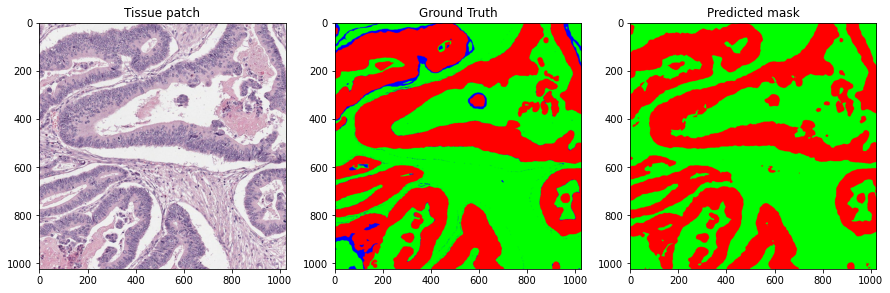

In [77]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(6)
ax[0].imshow(Image.open(name[0]))
ax[0].set_title('Tissue patch')
ax[1].imshow(final_gt)
ax[1].set_title('Ground Truth')
ax[2].imshow(final_out)
ax[2].set_title('Predicted mask')

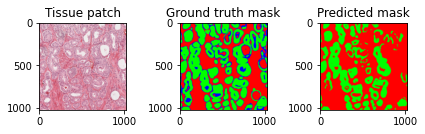

In [25]:
plt.subplot(1, 3, 1)  # row 1, column 2, count 1
plt.imshow(Image.open(name[0]))
plt.title('Tissue patch')
 
# using subplot function and creating plot two
# row 1, column 2, count 2
plt.subplot(1, 3, 2)
plt.imshow(np.moveaxis(mask[0],0,-1))
plt.title('Ground truth mask')

plt.subplot(1, 3, 3)
plt.imshow(output)
plt.title('Predicted mask')

plt.tight_layout()
 
# show plot
plt.show()

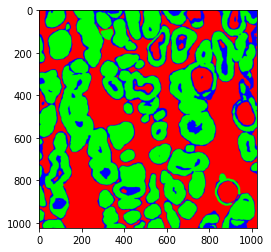

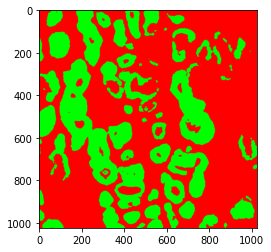

In [21]:
plt.figure()
plt.imshow(np.moveaxis(mask[0],0,-1))
plt.figure()
plt.imshow(output)

In [22]:
name

('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/333.jpg',)

In [12]:
mask.shape

(1, 3, 1024, 1024)

In [24]:
mask

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)